In [1]:
import sys
sys.path.insert(0, './py_torch_trpo')
from agent_file import agent
import gym
import scipy.optimize
import roboschool
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from gym import spaces
plt.style.use('seaborn-white')
sns.set(context = "paper", font = "monospace", font_scale=2)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('seaborn-white')
from baselines.common import set_global_seeds, tf_util as U
from baselines import bench
import gym, logging
import roboschool
from baselines import logger
from baselines.ppo1 import mlp_policy, pposgd_simple
from base_line_model.mlp import MlpPolicy_new
from base_line_model.PPO_agent import learning_agent

In [2]:
env = gym.make("RoboschoolWalker2d-v1")
env.seed(0)
np.random.seed(0)
seed = 1
logger.configure()
U.make_session(num_cpu=16).__enter__()
set_global_seeds(seed)

[2018-04-15 04:30:15,843] Making new env: RoboschoolWalker2d-v1


Logging to /tmp/openai-2018-04-15-04-30-15-848413


In [3]:
env2 = gym.make('RoboschoolWalker2d-v1')
env2 = bench.Monitor(env2, logger.get_dir(),allow_early_resets=True)
env2.seed(seed)
gym.logger.setLevel(logging.WARN)
class pargm(object):
    def __init__(self):
        self.timesteps_per_actorbatch = 25000#25000 # timesteps per actor per update
        self.clip_param = 0.2 
        self.entcoeff = 0.0 # clipping parameter epsilon, entropy coeff
        self.optim_epochs = 10 
        self.optim_stepsize = 3e-4
        self.optim_batchsize = 64# optimization hypers
        self.gamma = 0.99
        self.lam = 0.95 # advantage estimation
        self.max_timesteps=10e8#1e10 
        self.max_episodes=0 
        self.max_iters=0 
        self.max_seconds=0  # time constraint
        self.callback=None # you can do anything in the callback, since it takes locals(), globals()
        self.adam_epsilon=1e-5
        self.schedule='linear' # annealing for stepsize parameters (epsilon and adam)


def policy_fn(name, ob_space, ac_space):
        return MlpPolicy_new(name=name, ob_space=ob_space, ac_space=ac_space,
            hid_size=64, num_hid_layers=2)
    
parg = pargm()
agent2 = learning_agent('pi2', env2, policy_fn, parg)
agent2.restore('walker_mem')

[2018-04-15 04:30:16,285] Making new env: RoboschoolWalker2d-v1


INFO:tensorflow:Restoring parameters from walker_mem/data


[2018-04-15 04:30:17,011] Restoring parameters from walker_mem/data


In [4]:
class action_space(object):
    def __init__(self, env):
        self.env = env
        self.high = np.array([ 1,  1,  1,  1,  1])
        self.low = -np.array([ 1,  1,  1,  1,  1])
        self.shape = env.observation_space.shape
    
    def sample(self):
    
        return self.env.observation_space.sample()
        
        
class adversial_env(object):
    def __init__(self,ag):
        # parameter
        self.env = gym.make("RoboschoolWalker2d-v1")
        self.env.seed(0)
        self.ratio = 0.05 # change to 0.1 later in this script
        self.threshold = np.array([ 0.058152  ,  0.        ,  0.        ,  1.01691496,  0.        ,
        1.0058738 ,  0.        ,  0.12371043, 0,  0,
        0.44639227,  0,  0,  0,  0.34056485,
        0,  0,  0.23712605,  0,  0,
        0,  0])
        self.max_turn = 1000
        self.combine_ratio = 0.05
        
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.env.observation_space.shape[0],))
        self.observation_space = self.env.observation_space
        self.agent = ag
        self.obsr = 0
        self.epi_num = 0
        self.total_score = 0
        self.first = True
        self.run_avg = 0
        self.rvg_list = []
        self.score_list = []
        self.epi_list = []
        self.env.metadata
    
    # define reward function
    def reward(self, st):
        return np.abs(st[3])+0.2*np.abs(st[1])-0.08
    
    def step(self, a):
        self.epi_num = self.epi_num + 1
        
        obs = np.clip(a,-1,1)*self.threshold*self.ratio + self.obsr
        
        ac = self.agent.action_ev(obs)
        self.obsr, r, done, _ = self.env.step(ac)
        #print( np.clip(a,-1,1),np.clip(a,-1,1)*self.ratio)
        
        if self.epi_num >= self.max_turn:
            done = True
        
        if self.first and done: ###################################
            self.first = False
            self.run_avg = self.total_score
            self.score_list = [self.total_score]
            self.epi_list = [self.epi_num]
            print(self.run_avg, self.score_list, self.epi_list)
            
        
        final_r = -r
        if done and self.epi_num < self.max_turn:
            final_r = 15 # terminal cost 
        
        self.total_score += final_r
        return self.obsr, final_r, done, 0
        
        
    def seed(self, a):
        pass
    
    def reset(self):
        self.obsr = self.env.reset()
        #print(self.total_score)
        self.run_avg = (self.combine_ratio*self.total_score) + (1-self.combine_ratio)*self.run_avg
        #print(self.run_avg)
        #print(self.epi_num)
        
        if not self.first: #########################################
            self.rvg_list.append(self.run_avg)
            self.score_list.append(self.total_score)
            self.epi_list.append(self.epi_num)
        
        self.epi_num = 0
        self.total_score = 0
        return self.obsr
    
    def result_plot(self):
        fon_size = 19
        x = list(range(0, len(self.score_list[1:])))
        fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(1,2,1)
        plt.scatter(x,self.score_list[1:], s=5)
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('total reward',fontsize=fon_size)
        #plt.subplot(1,3,2)
        #plt.plot(self.rvg_list[1:])
        #plt.xlabel('episodes')
        #plt.ylabel('running average reward')
        plt.subplot(1,2,2)
        x = list(range(0, len(self.epi_list)))
        plt.scatter(x,self.epi_list, s=5)
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('time steps',fontsize=fon_size)
        plt.show()

# adversarial evaluation

In [5]:
import gym
import scipy.optimize
import roboschool
from agent_file import agent
import numpy as np
import random
from expert import *
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from gym import spaces
plt.style.use('seaborn-white')
sns.set(context = "paper", font = "monospace", font_scale=2)

In [6]:
class par(object):
    def __init__(self):
        self.gamma = 0.995
        self.env_name = "Reacher-v1"
        self.tau = 0.97
        self.l2_reg = 1e-3
        self.max_kl = 1e-2
        self.damping = 1e-1
        self.seed = 543
        self.batch_size = 25000
        self.max_epi = 6000
        self.log_interval = 1
        self.max_avg = 55
        
args = par()
env = adversial_env(agent2)
env.ratio = 0.1
agn = agent(env, args)
agn.load_model('adv_agent_model/adversarial_agent2_distr')

In [7]:
thres = np.array([ 0.058152  ,  0.        ,  0.        ,  1.01691496,  0.        ,
        1.0058738 ,  0.        ,  0.12371043, 0,  0,
        0.44639227,  0,  0,  0,  0.34056485,
        0,  0,  0.23712605,  0,  0,
        0,  0])

In [8]:
env = adversial_env(agent2)
env.ratio = 0.05
action = []
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    time = 0
    while done == False:   
        a = agn.select_action_deterministic(obs)
        action.append(np.clip(a,-1,1)*thres*0.05)
        time +=1
        obs, r, done, _ = env.step(a)
        if done:
            do = True

        score += r
    #print(score)

-445.55652983010674 [-445.55652983010674] [208]


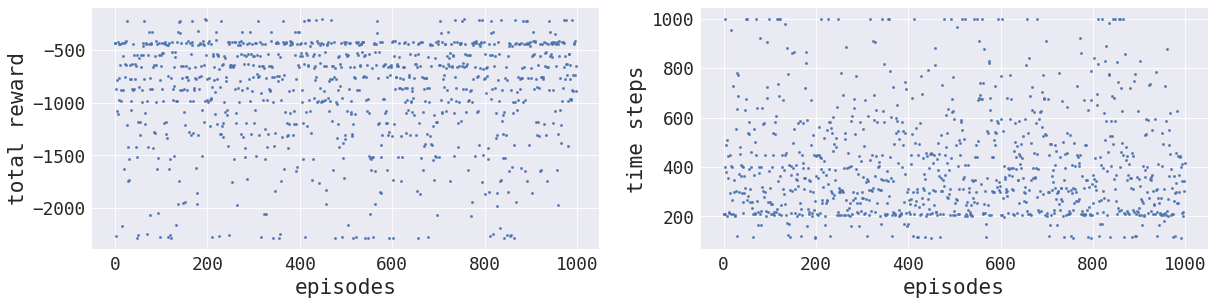

In [9]:
env.result_plot()

In [14]:
np.mean(env.score_list)

-885.61834575665819

In [10]:
np.array(action)

array([[ -1.44636735e-05,  -0.00000000e+00,  -0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,  -0.00000000e+00],
       [  7.80959197e-04,  -0.00000000e+00,  -0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,  -0.00000000e+00],
       [  1.09263552e-03,  -0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,  -0.00000000e+00],
       ..., 
       [  1.08654704e-03,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.58219971e-03,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.07972245e-03,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,  -0.00000000e+00]])

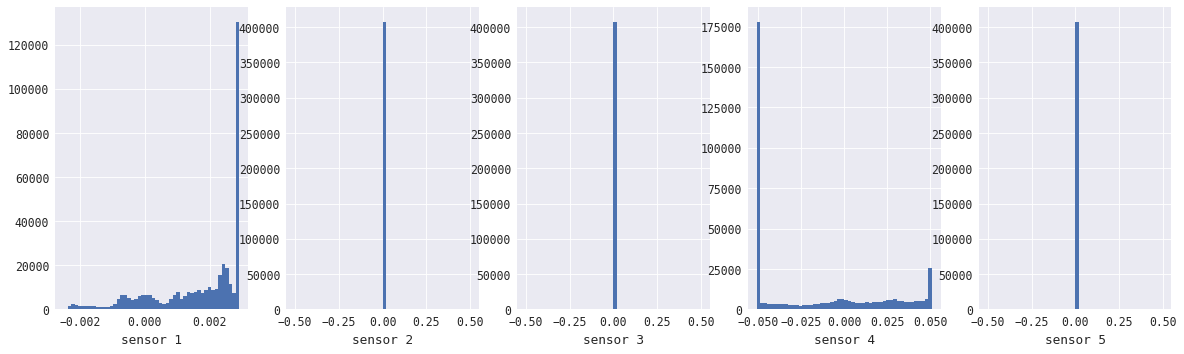

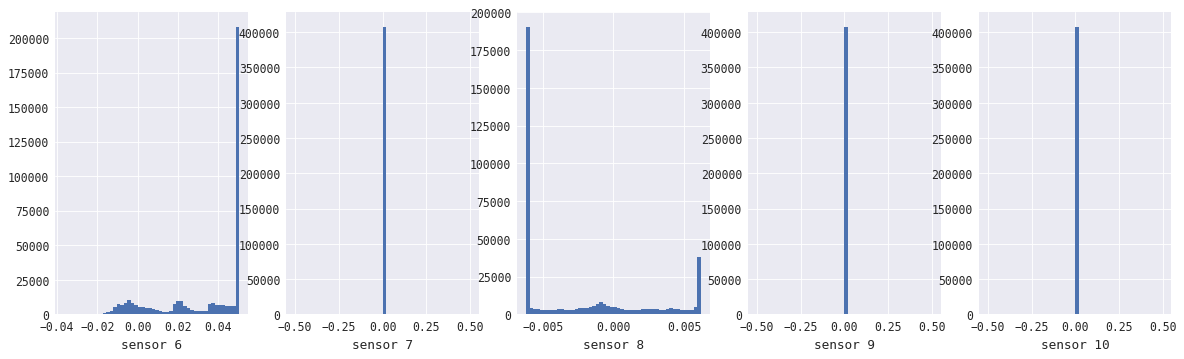

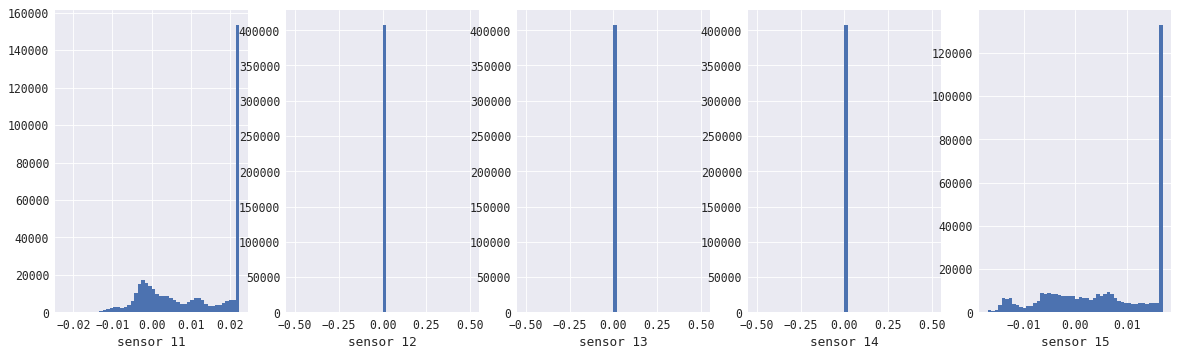

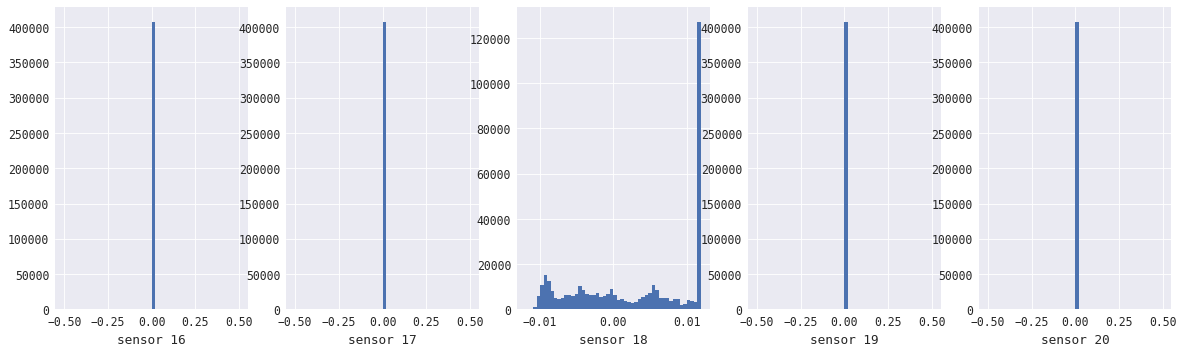

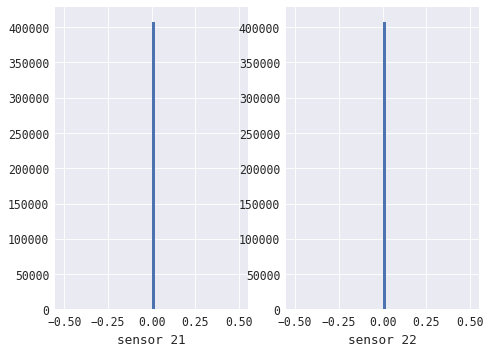

In [11]:
bin_num = 50
sensor_array = np.array(action)
fon_size = 17
sns.set(context = "paper", font = "monospace", font_scale=1.3)
fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,5,1)
plt.hist(sensor_array[:,0], bins = bin_num)
plt.xlabel('sensor 1')

plt.subplot(1,5,2)
plt.hist(sensor_array[:,1], bins = bin_num)
plt.xlabel('sensor 2')

plt.subplot(1,5,3)
plt.hist(sensor_array[:,2], bins = bin_num)
plt.xlabel('sensor 3')

plt.subplot(1,5,4)
plt.hist(sensor_array[:,3], bins = bin_num)
plt.xlabel('sensor 4')

plt.subplot(1,5,5)
plt.hist(sensor_array[:,4], bins = bin_num)
plt.xlabel('sensor 5')

plt.show()


bin_num = 50
sensor_array = np.array(action)
fon_size = 17
sns.set(context = "paper", font = "monospace", font_scale=1.3)
fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,5,1)
plt.hist(sensor_array[:,5], bins = bin_num)
plt.xlabel('sensor 6')

plt.subplot(1,5,2)
plt.hist(sensor_array[:,6], bins = bin_num)
plt.xlabel('sensor 7')

plt.subplot(1,5,3)
plt.hist(sensor_array[:,7], bins = bin_num)
plt.xlabel('sensor 8')

plt.subplot(1,5,4)
plt.hist(sensor_array[:,8], bins = bin_num)
plt.xlabel('sensor 9')

plt.subplot(1,5,5)
plt.hist(sensor_array[:,9], bins = bin_num)
plt.xlabel('sensor 10')

plt.show()
bin_num = 50
sensor_array = np.array(action)
fon_size = 17
sns.set(context = "paper", font = "monospace", font_scale=1.3)
fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,5,1)
plt.hist(sensor_array[:,10], bins = bin_num)
plt.xlabel('sensor 11')

plt.subplot(1,5,2)
plt.hist(sensor_array[:,11], bins = bin_num)
plt.xlabel('sensor 12')

plt.subplot(1,5,3)
plt.hist(sensor_array[:,12], bins = bin_num)
plt.xlabel('sensor 13')

plt.subplot(1,5,4)
plt.hist(sensor_array[:,13], bins = bin_num)
plt.xlabel('sensor 14')

plt.subplot(1,5,5)
plt.hist(sensor_array[:,14], bins = bin_num)
plt.xlabel('sensor 15')

plt.show()

bin_num = 50
sensor_array = np.array(action)
fon_size = 17
sns.set(context = "paper", font = "monospace", font_scale=1.3)
fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,5,1)
plt.hist(sensor_array[:,15], bins = bin_num)
plt.xlabel('sensor 16')

plt.subplot(1,5,2)
plt.hist(sensor_array[:,16], bins = bin_num)
plt.xlabel('sensor 17')

plt.subplot(1,5,3)
plt.hist(sensor_array[:,17], bins = bin_num)
plt.xlabel('sensor 18')

plt.subplot(1,5,4)
plt.hist(sensor_array[:,18], bins = bin_num)
plt.xlabel('sensor 19')

plt.subplot(1,5,5)
plt.hist(sensor_array[:,19], bins = bin_num)
plt.xlabel('sensor 20')

plt.show()

bin_num = 50
sensor_array = np.array(action)
fon_size = 17
sns.set(context = "paper", font = "monospace", font_scale=1.3)
fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,5,1)
plt.hist(sensor_array[:,20], bins = bin_num)
plt.xlabel('sensor 21')

plt.subplot(1,5,2)
plt.hist(sensor_array[:,21], bins = bin_num)
plt.xlabel('sensor 22')

plt.show()

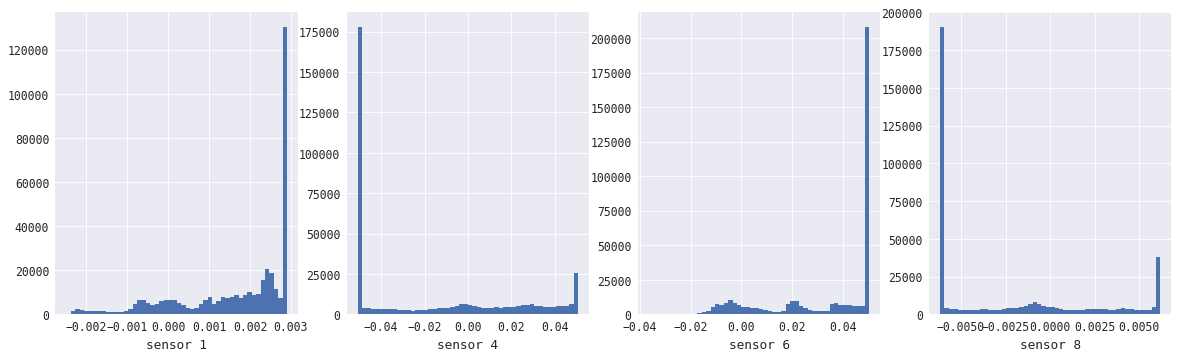

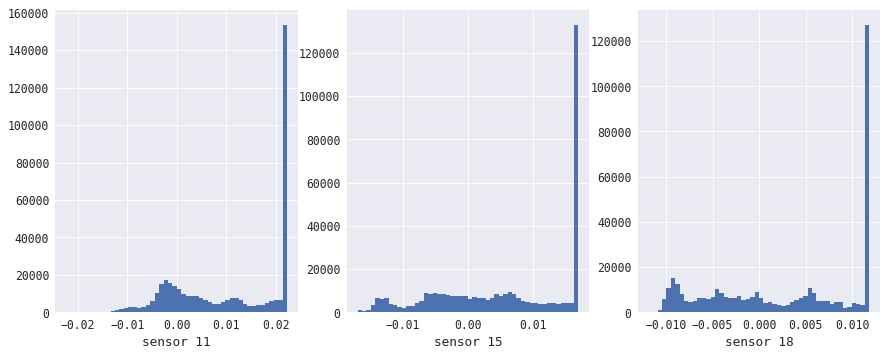

In [19]:
bin_num = 50
sensor_array = np.array(action)
fon_size = 17
sns.set(context = "paper", font = "monospace", font_scale=1.3)
fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,4,1)
plt.hist(sensor_array[:,0], bins = bin_num)
plt.xlabel('sensor 1')

plt.subplot(1,4,2)
plt.hist(sensor_array[:,3], bins = bin_num)
plt.xlabel('sensor 4')

plt.subplot(1,4,3)
plt.hist(sensor_array[:,5], bins = bin_num)
plt.xlabel('sensor 6')

plt.subplot(1,4,4)
plt.hist(sensor_array[:,7], bins = bin_num)
plt.xlabel('sensor 8')

plt.show()
fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,4,1)
plt.hist(sensor_array[:,10], bins = bin_num)
plt.xlabel('sensor 11')

plt.subplot(1,4,2)
plt.hist(sensor_array[:,14], bins = bin_num)
plt.xlabel('sensor 15')

plt.subplot(1,4,3)
plt.hist(sensor_array[:,17], bins = bin_num)
plt.xlabel('sensor 18')


plt.show()